**용어**
- BM25 (= BM11 + 14)
    - 현존 가장 좋은 알고리즘
    - 루씬, 엘라스틱서치에서 사용함.
    - 확률 기반(Prob)
- 

**들리는대로 일단 써!**
- p(d,q)는 ni라고 한다.
- IDF = log N/ni  -> 확률에서는 이렇게 표현한다.
- BM25는 TF-IDF의 변형이기도 하지만, 실제 만들어진 백그라운드가 확률 기반에서 나온 모델이다.
    - 기존 모델에 부가적인 정보를 더해보자 해서 만들어짐.
- P(D|R,q) P(R,q) / P(d|R(머리 위에 바), q), P(R(머리 위에 바), q)
    - odds
    - logistic regression으로 분류
    - 

### BM25
- https://en.wikipedia.org/wiki/Okapi_BM25
- 확률 기반이므로 score 자체가 곧 relevance이다. 따로 similarity 계산할 필요없이 바로 soriting만 하면 된다.

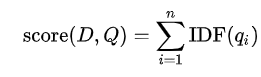
- 기존 모델
---

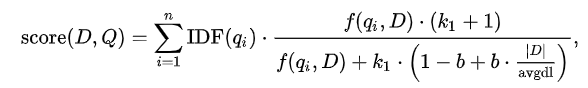
- BM25
- 뒤에 덧붙은 식이 부가적인 정보
- 덧붙은 식을 앞뒤로 나눠서 11, 14라고 함 (합쳐서 25라고 함)

In [4]:
from konlpy.corpus import kobill
from konlpy.tag import Kkma
from struct import pack, unpack
from collections import defaultdict


Lexicon = defaultdict(lambda:{"ptr":-1, "df":0})
# 단어:{위치, 총몇개의문서}

Documents = defaultdict(lambda:{
    "length":0.0, "ttf":0, "max":0})
# 문서:(문서벡터의길이, 총몇개의단어, 이문서에서가장많이나온단어의빈도)
# ttf = total term frequency

DocumentsList = list()
# 인덱스:문서의제목

kkma = Kkma()
# 형태소분석기(꼬꼬마)

fp = open("inverted.dat", "wb")
# TDM(frequency)

for docName in kobill.fileids():
    # Local
    document = kobill.open(docName).read() # 개별문서
    localPostings = defaultdict(int) # 각 문서의 TDM(Vector)
    # 문서정보 저장
    DocID = len(DocumentsList) # 문서의 제목 -> 숫자
    DocumentsList.append(docName) # 해당 숫자(위치)  제목 저장
    # 각 문서에서 색인어 추출 방식 (형태소분석기, 형태소의길이로정규화)
    for term in [_ for _ in kkma.morphs(document)
              if 1 < len(_) < 6]:
        localPostings[term] += 1
        # 문서 벡터 생성 (열 단어:빈도)
    # 문서의 통계정보 저장 => for weight
    Documents[DocID]["ttf"] = sum(localPostings.values())
    Documents[DocID]["max"] = max(localPostings.values())
    # Global
    for term, freq in localPostings.items():
        ptr = Lexicon[term]["ptr"]
        # 1. 단어가 첫 등장: 위치 ptr=-1
        # 2. 단어가 있을 때, ptr= 마지막 저장 위치
        postingPtr= fp.tell()
        # 파일의 어느 위치에 저장하는 지 
        fp.write(pack("iii", DocID, freq, ptr))
        # 구조체를 저장(int, int, int)
        Lexicon[term]["ptr"] = postingPtr
        # 1.1 위치 변경 : 파일의 위치
        Lexicon[term]["df"] += 1
        # for IDF
        
fp.close()

C:\Users\JINHYO\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [6]:
# 3. BM25
from math import log

Query = "현행법은 입법예고와 행정예고를 통하여 정책 결정 과정에"
Query = kobill.open('1809896.txt').read()

queryTerms = [_ for _ in kkma.morphs(Query)
              if 1 < len(_) < 6]

searchResult = defaultdict(float)
fp = open("inverted.dat", "rb")

k = 1.2
b = 0.75
N = len(DocumentsList)
sumDocLength = sum([_["ttf"] for _ in Documents.values()]) 
avgDocLength = sumDocLength/N
    
for term in queryTerms:
    ptr = Lexicon[term]["ptr"]
    df = Lexicon[term]["df"]
    while ptr != -1:
        fp.seek(ptr)
        _struct = unpack("iii", fp.read(4*3))
        docID = _struct[0]
        termFreq = _struct[1]
        docLength = Documents[docID]["ttf"]
        TF = (termFreq*(k+1))/(termFreq+k*(1-b+b*(docLength/avgDocLength)))
        IDF = log(1+(N-df+0.5)/(df+0.5))
        searchResult[_struct[0]] += TF*IDF
        ptr = _struct[-1]
fp.close()

for d, dist in {_[0]:_[1]
                for _ in sorted(searchResult.items(), 
                                key=lambda r:r[1], 
                                reverse=True)}.items():
    print({d:{"각도":dist, "단어수": Documents[d]["ttf"]}})
    print("\n".join(kobill.open(DocumentsList[d]).read().\
                     splitlines()[:3]))

{6: {'각도': 2990.2534692300214, '단어수': 1803}}
행정절차법 일부개정법률안

(유선호의원 대표발의 )
{9: {'각도': 607.1829559418804, '단어수': 1855}}
결혼중개업의 관리에 관한 법률 일부개정법률안

(한선교의원 대표발의 )
{5: {'각도': 407.28006795344237, '단어수': 346}}
하도급거래 공정화에 관한 법률 일부개정법률안

(유선호의원 대표발의 )
{3: {'각도': 404.6064009602216, '단어수': 893}}
남녀고용평등과 일 ·가정 양립 지원에 관한 법률 

일부개정법률안
{1: {'각도': 395.07560184860904, '단어수': 883}}
국가공무원법 일부개정법률안

(정의화의원 대표발의 )
{0: {'각도': 385.76766016398534, '단어수': 883}}
지방공무원법 일부개정법률안

(정의화의원 대표발의 )
{2: {'각도': 369.5576948854862, '단어수': 1039}}
교육공무원법 일부개정법률안

(정의화의원 대표발의 )
{7: {'각도': 357.7175587667044, '단어수': 672}}
국군부대의 아랍에미리트(UAE)군 교육훈련 지원 등에 
관한 파견 동의안

{8: {'각도': 316.6549664702179, '단어수': 642}}
국군부대의 소말리아 해역 파견연장 동의안

의안
{4: {'각도': 247.26542701760593, '단어수': 213}}
고등교육법 일부개정법률안

(안상수의원 대표발의 )


---

### 다음주 할거 (맛보기)

In [12]:
from os import listdir
fileids = lambda: ["practice/8일차_실습_project/헤드라인/" + _ for _
                  in listdir("practice/8일차_실습_project/헤드라인/")
                  if _.split(".")[-1] == "txt"
                  and len(_.split("-")) > 1]

In [14]:
len(fileids())

144

In [17]:
def read(file):
    with open(file, "r", encoding="utf-8") as fp:
        doc = fp.read()
    return doc

In [19]:
# 고유명사인데 분리시키는 문제가 있음.
# POS만 쓸수는 없음
# N-gram 같이 쓰면 해결될 것!
# 모든 tokenize는 하나만 써서 성능이 잘 나올 수 없음! 자기가 잘 섞어 써야지!

from konlpy.tag import Kkma
Kkma().pos("포드 머스텡 불리트")

[('포드', 'NNG'), ('머', 'MAG'), ('스텡', 'UN'), ('불', 'XPN'), ('리트', 'NNG')]

## 복습

**전처리** => RE

**Tokenizing**
    - split (원시 어절)
    - sent_tokenize
    - word_tokenize(구두점 분리한 어절)
    - regexp_tokenize => re
    - N-gram(어절, 음절), BPE(Stemming, 어간분리)
    - Lemmatization(어근분리, 우리는 따로 안했음)->Morpheme Analyzer(with POS)
    
**Normalization**
    -zipf(Text객체, freq=비율)
    - -> 고빈도, 저빈도, 중빈도(10%)
    -토큰의 길이, 품사로 정규화(조사, 어미, .. X)

**Parse Tree**
    -NP, Vp => 명사구

In [21]:
corpus

'// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_removeCallback() {}\n\nCJ ENM 및 JTBC.국내 동영상스트리밍서비스(OTT) 시장을 둘러싼 싸움이 대전으로 번지고 있다. 지상파 방송 3사(KBSㆍMBCㆍSBS)와 거대 통신사 SK텔레콤이 합작 OTT 웨이브의 출범(18일)을 알리자마자 국내 대표 케이블채널 사업자인 CJ ENM과 JTBC가 합작 OTT 설립을 발표했다. OTT를 중심으로 한 국내 방송업계 재편이 급물살을 타게 됐다.CJ ENM과 JTBC는 통합 OTT 합작법인을 내년 초까지 출범시키겠다는 내용의 양해각서(MOU)를 체결했다고 17일 밝혔다. 합작법인은 CJ ENM이 1대 주주이며, JTBC가 2대 주주로 참여한다. 통합 OTT는 CJ ENM이 운영하는 OTT 티빙을 기반으로 이뤄질 예정이다. CJ ENM은 인기 케이블채널 tvN과 OCN, 엠넷 등을 보유하고 있는 방송업계 강자다. JTBC는 종합편성(종편) 채널 중 매출액이 가장 높은 방송시장의 신흥 강호다.CJ ENM과 JTBC의 통합 OTT 설립 논의는 지난해부터 이뤄졌다. 세계 최대 OTT인 넷플릭스가 지난해부터 드라마 ‘킹덤’ 등 국내 콘텐츠 투자에 본격적으로 나서면서부터다. 픽사와 마블 등을 거린 월트 디즈니의 OTT 디즈니플러스가 내년 한국 진출을 예고한 점도 두 회사의 연합을 재촉했다. CJ ENM과 JTBC는 ‘미스터 션샤인’과 ‘스카이캐슬’ 등 자사 인기 콘텐츠의 판권을 넷플릭스에 판매하는 식으로 OTT시장에 진출하는 전략을 취해 왔었다. 국내 동영상 시장이 OTT 위주로 급속히 재편되자 합작 법인 설립으로 전략을 급선회하게 됐다. 웨이브의 출범도 두 회사의 ‘동맹’에 큰 영향을 준 것으로 보인다. JTBC 관계자는 “방송ㆍ영상 사업은 속도를 가늠하기 어려울 정도로 빠르게 변화하고 있다”며 “결국 차별화된 콘텐츠를 끊임없이 생산할 뿐만 아니라, 적절히 유통할 수 이는 시스템 구축이 필수적“이라고 밝혔다.두 회사는 콘텐츠에서

In [30]:
re.findall("[a-z]{3,}@[a-z]{3,}[.][a-z]{2,}", corpus)

['realnine@hankookilbo.com']

In [49]:
import re
corpus = read(fileids()[0])

pattern = dict()
pattern["email"] = re.compile(
    r"[a-z]{3,}@[a-z]{3,}[.][a-z]{2,}")
pattern["domain"] = re.compile(
    r"[a-z]{3,}[.][a-z]{2,}")
pattern["punc"] = re.compile(
    r"[{}]".format(re.escape("(){}/\"'`")))
pattern["code"] = re.compile(
    r"\b[A-Za-z_]{5,}\b")
pattern["nonkor"] = re.compile(
    r"\b[^.0-9ㄱ-ㅎㅏ-ㅣ가-힣]+\b")
pattern["whitespace"] = re.compile(
    r"\s{2,}")


pattern["email"].sub(" ", corpus)
pattern["domain"].sub(" ",corpus)
pattern["punc"].sub(" ", corpus)
pattern["code"].sub(" ", corpus)
pattern["nonkor"].sub(" ", corpus)
pattern["whitespace"].sub(" ", corpus)

from copy import copy
corpus_ = copy(corpus)
for _ in ["email","punc", "code", "nonkor", "whitespace"]:
    corpus_ = pattern[_].sub(" ", corpus_)
    
corpus_

' 오류를 우회하기 위한 함수 추가 및 .국내 동영상스트리밍서비스 시장을 둘러싼 싸움이 대전으로 번지고 있다. 지상파 방송 3사 와 거대 통신사 SK텔레콤이 합작 웨이브의 출범 18일 을 알리자마자 국내 대표 케이블채널 사업자인 ENM과 JTBC가 합작 설립을 발표했다. OTT를 중심으로 한 국내 방송업계 재편이 급물살을 타게 됐다. ENM과 JTBC는 통합 합작법인을 내년 초까지 출범시키겠다는 내용의 양해각서 를 체결했다고 17일 밝혔다. 합작법인은 ENM이 1대 주주이며 JTBC가 2대 주주로 참여한다. 통합 OTT는 ENM이 운영하는 티빙을 기반으로 이뤄질 예정이다. ENM은 인기 케이블채널 tvN과 엠넷 등을 보유하고 있는 방송업계 강자다. JTBC는 종합편성 종편 채널 중 매출액이 가장 높은 방송시장의 신흥 강호다. ENM과 JTBC의 통합 설립 논의는 지난해부터 이뤄졌다. 세계 최대 OTT인 넷플릭스가 지난해부터 드라마 킹덤 등 국내 콘텐츠 투자에 본격적으로 나서면서부터다. 픽사와 마블 등을 거린 월트 디즈니의 디즈니플러스가 내년 한국 진출을 예고한 점도 두 회사의 연합을 재촉했다. ENM과 JTBC는 미스터 션샤인 과 스카이캐슬 등 자사 인기 콘텐츠의 판권을 넷플릭스에 판매하는 식으로 OTT시장에 진출하는 전략을 취해 왔었다. 국내 동영상 시장이 위주로 급속히 재편되자 합작 법인 설립으로 전략을 급선회하게 됐다. 웨이브의 출범도 두 회사의 동맹 에 큰 영향을 준 것으로 보인다. 관계자는 방송ㆍ영상 사업은 속도를 가늠하기 어려울 정도로 빠르게 변화하고 있다 며 결국 차별화된 콘텐츠를 끊임없이 생산할 뿐만 아니라 적절히 유통할 수 이는 시스템 구축이 필수적 이라고 밝혔다.두 회사는 콘텐츠에서 상대적 우위를 차지하고 있다. ENM은 시가총액 1억9 000억원대인 국내 최대 드라마 제작사 스튜디오드래곤을 자회사로 두고 있다. 예능프로그램 삼시세끼 등의 나영석 드라마 응답하라 시리즈의 신원호 등 스타 PD들이 ENM에 소속돼 있다. ENM은 영화 명량 과 

In [67]:
V1 = list()
for _ in corpus_.split():
    V1.append(_)
print("원시어절", len(V1), len(set(V1)))

V2 = list()
from nltk.tokenize import word_tokenize
for _ in corpus_.split():
    for token in word_tokenize(_):
        V2.append(token)
print("어절분리", len(V2), len(set(V2)))

V3 = list()
from nltk.tokenize import regexp_tokenize
for _ in corpus_.split():
    for token in regexp_tokenize(_, r"\b\w+\b"):
        V3.append(token)
print("정규식분리", len(V3), len(set(V3)))

V4 = list()
for _ in corpus_.split():
    for token in ["/".join(_) for _ in kkma.pos(_)]:
        V4.append(token)
print("품사", len(V4), len(set(V4)))

V5 = list()
for _ in corpus_.split():
    tokens = kkma.morphs(_)
    for i in range(len(tokens)-1):
        V5.append(" ".join(tokens[i:i+2]))
print("형태소 바이그램", len(V5), len(set(V5)))

원시어절 438 343
어절분리 471 344
정규식분리 442 339
품사 931 380
형태소 바이그램 493 330


In [84]:
len(V1+V2+V3+V4+V5), \
len(set(V1+V2+V3+V4+V5).intersection(V6))

(2775, 34)

In [80]:
V6 = list()
for _ in corpus_.split():
    tokens = [_[0] for _ in kkma.pos(_) 
              if re.search(r"^NN|NP", _[1])]
    for i in range(len(tokens)-1):
              V6.append(tokens[i])
              V6.append(" ".join(tokens[i:i+2]))

In [83]:
print("품사분리(명사)", len(V6), len(set(V6)))

품사분리(명사) 78 57


In [79]:
V6

['동영상',
 '동영상 스트리밍',
 '스트리밍',
 '스트리밍 서비스',
 '출범',
 '출범 일',
 '일',
 '일 을',
 '케이블',
 '케이블 채널',
 '방송',
 '방송 업계',
 '급',
 '급 물살',
 '합작',
 '합작 법인',
 '양해',
 '양해 각서',
 '합작',
 '합작 법인',
 '케이블',
 '케이블 채널',
 '방송',
 '방송 업계',
 '종합',
 '종합 편성',
 '편성',
 '편성 종편',
 '방송',
 '방송 시장',
 '킹',
 '킹 덤',
 '디즈니',
 '디즈니 플러스',
 '방송',
 '방송 영상',
 '시가',
 '시가 총액',
 '원',
 '원 대인',
 '스튜디오',
 '스튜디오 드래곤',
 '예능',
 '예능 프로그램',
 '삼시',
 '삼시 세끼',
 '명',
 '명 량',
 '량',
 '량 과',
 '극',
 '극 직업',
 '국제',
 '국제 시장',
 '투자',
 '투자 배급',
 '큰손',
 '큰손 기도',
 '예능',
 '예능 프로그램',
 '방송',
 '방송 시장',
 '경쟁',
 '경쟁 관계인',
 '합작',
 '합작 법인',
 '디즈니',
 '디즈니 플러스',
 '투자',
 '투자 년',
 '자유',
 '자유 경쟁',
 '경쟁',
 '경쟁 시장',
 '계약',
 '계약 기간',
 '요금',
 '요금 제가',
 '베이',
 '베이 직',
 '강',
 '강 진구',
 '한국',
 '한국 일보',
 '페이스',
 '페이스 북',
 '한국',
 '한국 일보',
 '가기',
 '가기 네이버',
 '한국',
 '한국 일보']

In [82]:
kkma.tagset

{'EC': '연결 어미',
 'ECD': '의존적 연결 어미',
 'ECE': '대등 연결 어미',
 'ECS': '보조적 연결 어미',
 'EF': '종결 어미',
 'EFA': '청유형 종결 어미',
 'EFI': '감탄형 종결 어미',
 'EFN': '평서형 종결 어미',
 'EFO': '명령형 종결 어미',
 'EFQ': '의문형 종결 어미',
 'EFR': '존칭형 종결 어미',
 'EP': '선어말 어미',
 'EPH': '존칭 선어말 어미',
 'EPP': '공손 선어말 어미',
 'EPT': '시제 선어말 어미',
 'ET': '전성 어미',
 'ETD': '관형형 전성 어미',
 'ETN': '명사형 전성 어미',
 'IC': '감탄사',
 'JC': '접속 조사',
 'JK': '조사',
 'JKC': '보격 조사',
 'JKG': '관형격 조사',
 'JKI': '호격 조사',
 'JKM': '부사격 조사',
 'JKO': '목적격 조사',
 'JKQ': '인용격 조사',
 'JKS': '주격 조사',
 'JX': '보조사',
 'MA': '부사',
 'MAC': '접속 부사',
 'MAG': '일반 부사',
 'MD': '관형사',
 'MDN': '수 관형사',
 'MDT': '일반 관형사',
 'NN': '명사',
 'NNB': '일반 의존 명사',
 'NNG': '보통명사',
 'NNM': '단위 의존 명사',
 'NNP': '고유명사',
 'NP': '대명사',
 'NR': '수사',
 'OH': '한자',
 'OL': '외국어',
 'ON': '숫자',
 'SE': '줄임표',
 'SF': '마침표, 물음표, 느낌표',
 'SO': '붙임표(물결,숨김,빠짐)',
 'SP': '쉼표,가운뎃점,콜론,빗금',
 'SS': '따옴표,괄호표,줄표',
 'SW': '기타기호 (논리수학기호,화폐기호)',
 'UN': '명사추정범주',
 'VA': '형용사',
 'VC': '지정사',
 'VCN': "부정 지정사, 형용사 '아니다'",
 'VC